

I have coded this is Spyder and then moved it to Jupyter Notebook.

 8/2021       Rasoul Hekmati
Import the Libraries Pandas, math, Sklearn etc.

In [ ]:
# Import the libraries
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from yellowbrick.target import FeatureCorrelation
from sklearn.metrics import mutual_info_score
%matplotlib inline

Read the data for each city, remove/interpolate nans, and add 'PM' column

In [ ]:
#------------------------------------Read the data, explore, preprocess and clean
DIRECTION_PATH = r"C:\Users\13467\Downloads\FiveCitiesPMData"# Adjust this to your current directory  ---> I code this in Spyder
all_cities_data = os.listdir(DIRECTION_PATH)
for city_id in range(len(all_cities_data)):# for each city, take the corresponding  file
    data = pd.read_csv(os.path.join(DIRECTION_PATH, all_cities_data[city_id]))
    cols = list(data.columns)# list of the features
    pm_cols = []# columns starting with PM
    for col in cols:
        if col.startswith('PM'):
            pm_cols.append(col)

    non_PM_columns = []# Explanatory features: columns that are not starting with a PM
    for col in cols:
        if not col.startswith('PM'):
            non_PM_columns.append(col)
    #interpolate 2 columns with nan values
    data['precipitation']=data['precipitation'].interpolate(limit_direction='both')
    data['Iprec']=data['Iprec'].interpolate(limit_direction='both')
    # detect the raws with nan for non-pm features
    nan_rows_indexes = []
    for i, (index, row) in enumerate(data.iterrows()):
        if row[non_PM_columns].isnull().any(): 
            nan_rows_indexes.append(index)

    data = data.drop(nan_rows_indexes)# drop the rows with nan
    #add 'PM'' as a new column PM = mean( PM columns)
    non_PM_columns.append('PM') 
    temporary_data = []#temporary data to store the mean pm
    for i, (index, row) in enumerate(data.iterrows()):
        average_pms = row[pm_cols].mean()
        if not math.isnan(average_pms):
            temporary_row = row.reindex(non_PM_columns)
            temporary_row['PM'] = average_pms
            temporary_data.append(temporary_row)
        
    data2 = pd.DataFrame(columns = non_PM_columns)# make a DF out of temporary data
    data2 = data2.append(temporary_data, ignore_index=True)
    data2['city']=city_id+1# new feature for the city  
    globals()[f"Cleaned_data_city{city_id+1}"] = data2# dynamic naming of the data for each city


Concatenate data from 5 cities into 1 csv file

In [ ]:
data = pd.DataFrame()# Final data with all the cities
for city_id in range(len(all_cities_data)):# for each city
    data = data.append(globals()[f"Cleaned_data_city{city_id+1}"], ignore_index=True)    
data = data.drop(['No'], axis=1)# drop the 'NO' column

ordinalencoder = OrdinalEncoder()# ordinal encoding of cbwd columns 
data['cbwd']=ordinalencoder.fit_transform(data[['cbwd']])
file_path = os.path.join(DIRECTION_PATH, 'Collapsed_data.csv')
data.to_csv(file_path)# print the final cleaned and concatenated file


Feature Importance  --- Correlation between explanatory variables and respnse variable

In [ ]:
#Feature Engineering   Correlation
visualizer = FeatureCorrelation(labels=non_PM_columns)
visualizer.fit(data.loc[:,non_PM_columns.remove(['No','PM'])], data.loc[:,'PM'])        # Fit the data to the visualizer
visualizer.show()   

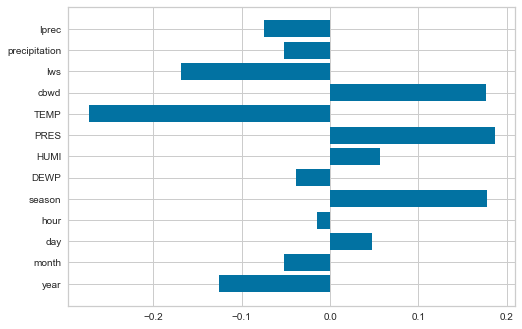

Feature Importance  --- Mutual Information between explanatory variables and respnse variable

In [ ]:
#Feature Engineering   Mutual Information
MI=[0]*len(non_PM_columns)# matrix 0 to save MI values
for i in range(len(non_PM_columns)):
    MI[i]=mutual_info_score(data.loc[:,non_PM_columns[i]], data.loc[:,'PM'])
plt.barh(np.arange(len(MI)),MI)
plt.title('MI between each feature and PM')
plt.yticks(np.arange(len(MI)),non_PM_columns)

Features: 1=Year 2=Month 3=Day 4=Hour 5=Season 6=DEWP 7= HUMI 8= PRES 9=TEMP 10=CBWD 11=LWS 12= Precipitation 13=Iprec

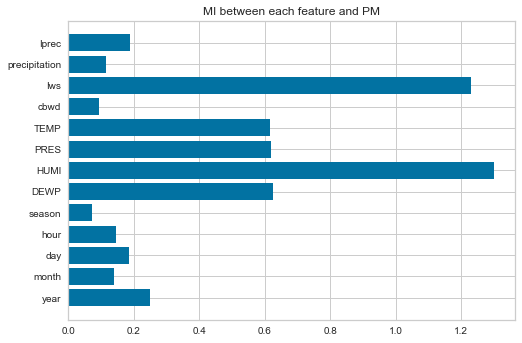

Train test splitting and normalization 

In [ ]:
# Scaling and Transforming the Data
train_set, test_set = train_test_split(data, test_size=0.2, random_state=1)
print('Number of Train samples:', len(train_set), '\n number of Test samples: ', len(test_set))

train_Set_label= train_set['PM'].copy()# PM for tran set
train_Set = train_set.drop("PM", axis=1)# train set
scaler = StandardScaler().fit(train_set)# normalization x-mu/sigma

test_Set_label= test_set['PM'].copy()# pm for the test set
test_Set = test_set.drop("PM", axis=1)# the test set 
scaler = StandardScaler().fit(test_set)

Linear Regression and important features based on regression coefficient

In [ ]:
#Train the Time Series Forecasting Model  -  LR
lin_reg = LinearRegression()
lin_reg_scores = cross_val_score(lin_reg, train_Set, train_Set_label,  scoring="neg_mean_squared_error", cv=5)# cross validation erroe
print('Linear Regression CV average MSE: ', lin_reg_scores.mean())
print('Average RMSE: ', np.sqrt(abs(lin_reg_scores.mean())))
lin_reg.fit(train_Set, train_Set_label)
# get importance
importance = lin_reg.coef_
plt.bar([x for x in range(len(importance))], importance)
plt.title('LR - Feature Importance')
plt.xlabel(data.columns)
plt.show()

Features: 1=Year 2=Month 3=Day 4=Hour 5=Season 6=DEWP 7= HUMI 8= PRES 9=TEMP 10=CBWD 11=LWS 12= Precipitation 13=Iprec

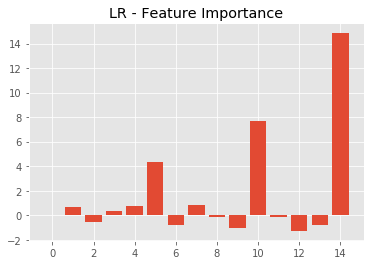

Decision Tree and important features

In [ ]:
#Train the Time Series Forecasting Model  -  DT
tree_reg = DecisionTreeRegressor(max_features=10, max_depth=25)
tree_reg_scores = cross_val_score(tree_reg, train_Set, train_Set_label,scoring="neg_mean_squared_error", cv=5)
print('Decision Tree CV average MSE: ', tree_reg_scores.mean())
print('Decision Tree RMSE: ', np.sqrt(abs(tree_reg_scores.mean())))
tree_reg.fit(train_Set, train_Set_label)
# get importance
importance = tree_reg.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.title('Decision Tree - Feature Importance')
plt.xlabel(data.columns)
plt.show()

Features: 1=Year 2=Month 3=Day 4=Hour 5=Season 6=DEWP 7= HUMI 8= PRES 9=TEMP 10=CBWD 11=LWS 12= Precipitation 13=Iprec

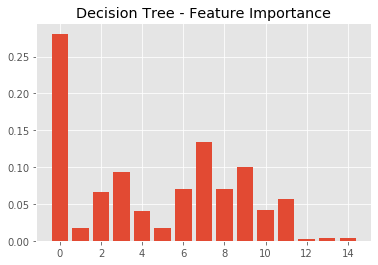

Random Forest and important features

In [ ]:
##Train the Time Series Forecasting Model  -  RF
random_forest_reg = RandomForestRegressor(n_estimators=100, max_features=10, max_depth=15)
random_forest_reg_scores = cross_val_score(random_forest_reg, train_Set, train_Set_label,scoring="neg_mean_squared_error", cv=5)
print('Random Forest CV average MSE: ', random_forest_reg_scores.mean())
print('Random Forest RMSE: ', np.sqrt(abs(random_forest_reg_scores.mean())))
random_forest_reg.fit(train_Set, train_Set_label)
# get importance
importance = random_forest_reg.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.title('Random Forest - Feature Importance')
plt.xlabel(data.columns[:-2])
plt.show()

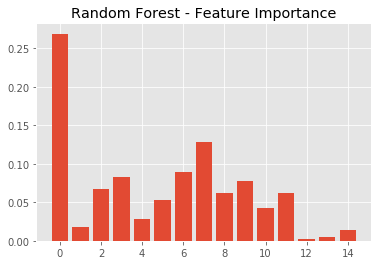

MLP Regressor

In [ ]:
#Train the Time Series Forecasting Model  -  MLP
regressor=MLPRegressor(hidden_layer_sizes=(50,10), activation='relu', solver='adam', alpha=0.0001,random_state=0)
regressor.fit(train_Set,train_Set_label)
MLP_reg_scores = cross_val_score(regressor, train_Set, train_Set_label,scoring="neg_mean_squared_error", cv=5)
print('MLP CV average MSE: ', MLP_reg_scores.mean())
print('MLP RMSE: ', np.sqrt(abs(MLP_reg_scores.mean())))
regressor.predict(test_Set)
regressor.score(test_Set, test_Set_label)

XGBoost Regressor

In [ ]:
#Train the Time Series Forecasting Model  -  XG
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
model_xg = XGBRegressor()
model_xg.fit(train_Set, train_Set_label)
model_xg.predict(test_Set)
model_xg.score(test_Set, test_Set_label)
# get importance
importance = model_xg.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.title('XGBoost - Feature Importance')
plt.show()

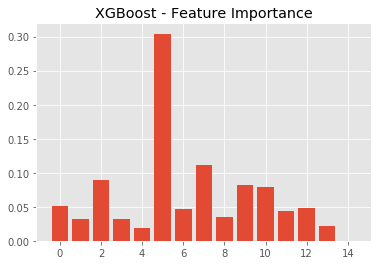

MLP Keras ----> not working due to the core-tensorflow error
LSTM      ----> not working due to the allocation error

In [ ]:
#---------------------------------------------MLP keras
# from tensorflow import keras 
# from keras.models import Sequential
# from keras import optimizers
# from keras.layers import Dense
# epochs = 40
# batch = 256
# lr = 0.0003
# adam = optimizers.Adam(lr)
# model_mlp = Sequential()
# model_mlp.add(Dense(10, activation='relu', input_dim=train_Set.shape[1]))
# model_mlp.add(Dense(1))
# model_mlp.compile(loss='mse', optimizer=adam)
# model_mlp.summary()
# ----------------------------------------------LSTM
# from tensorflow.keras.layers import LSTM
# from keras.models import Sequential
# from keras.layers import Dense
# from pandas import concat
# from numpy import concatenate
# from math import sqrt
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_Set.shape[1], train_Set.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
# history = model.fit(train_Set.iloc[1:101,:], train_Set_label.iloc[1:101,:], epochs=50, batch_size=72, validation_data=(test_Set, test_Set_label), verbose=2, shuffle=False)
# # plot history
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()
# yhat = model.predict(test_Set)
# test_Set = test_Set.reshape((test_Set.shape[0], test_Set.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_Set[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_Set_label.reshape((len(test_Set_label), 1))
# inv_y = concatenate((test_Set_label, test_Set[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)



 Test evaluation avd visualization

In [ ]:
#Evaluate Model Performance
def model_evaluation(model, test, test_labels):# function to summerize MSE,RMSE,R2
    predicted_value = model.predict(test)
    model_mse = mean_squared_error(test_labels, predicted_value)
    model_rmse = np.sqrt(model_mse)
    model_r2 = abs(r2_score(test_labels, predicted_value))
    print('TEST SET EVALUATION', '\nMSE: ', model_mse, '\nRMSE: ', model_rmse, '\nR2 score: ', model_r2)
    summary = [model_mse, model_rmse, abs(model_r2)]
    return predicted_value, summary\
        
def model_accuracy_plot(actual, predicted):
    fig,ax = plt.subplots()
    ax.scatter(actual, predicted)
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'b--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    fig.show()
    
# LR    
lin_reg_predictions, lin_reg_results = model_evaluation(lin_reg, test_Set, test_Set_label)
model_accuracy_plot(test_Set_label, lin_reg_predictions)
# DT
tree_predictions, tree_results = model_evaluation(tree_reg, test_Set, test_Set_label)
model_accuracy_plot(test_Set_label, tree_predictions)
# RF
rnd_clf_predictions, rnd_clf_results = model_evaluation(random_forest_reg, test_Set, test_Set_label)
model_accuracy_plot(test_Set_label, rnd_clf_predictions)
#MLP
MLP_predictions, MLP_results = model_evaluation(regressor, test_Set, test_Set_label)
model_accuracy_plot(test_Set_label, MLP_predictions)
#XGBoost
xg_predictions, xg_results = model_evaluation(model_xg, test_Set, test_Set_label)
model_accuracy_plot(test_Set_label, xg_predictions)
# sumemrize all the results
results_final = [lin_reg_results, tree_results, rnd_clf_results,MLP_results,xg_results]


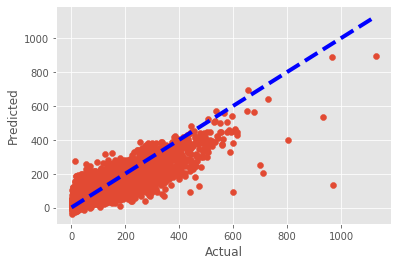

Benchmark the methods

In [ ]:
# overview of Selected Models
def plot_result(title, results, metrics_index):
    list_of_models = ['Linear Regression', 'Decision Tree', 'Random Forest','MLP','XGBoost']
    values = []
    for model in results:
        values.append(model[metrics_index])

    x_for_each_model = [i for i, _ in enumerate(list_of_models)]
    plt.stem(values)
    plt.xlabel("Models")
    plt.ylabel("Value")
    plt.title(title)
    plt.xticks(x_for_each_model, list_of_models)
    plt.show()
plot_result(title='Mean Square Error', results=results_final, metrics_index=0)
plot_result(title='Root Mean Square Error', results=results_final, metrics_index=1)
plot_result(title='R2 score', results=results_final, metrics_index=2)


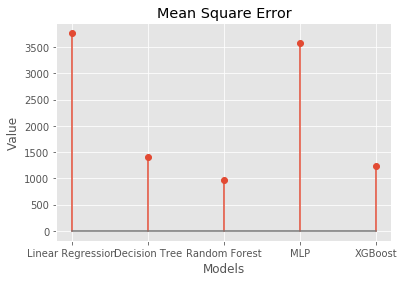

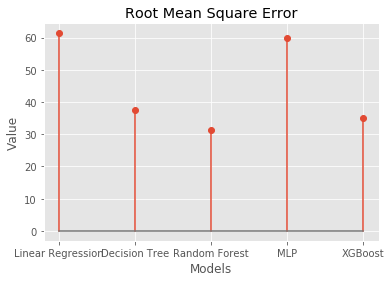

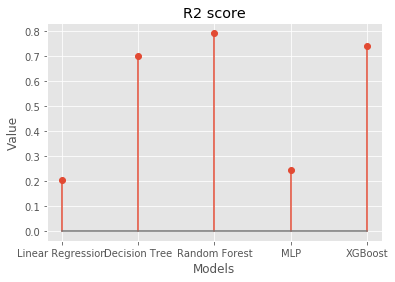

Use elbow method to define a threshold for being "high", get the predictions from different methods and plot the sorted version of them, then detect the turn point. Finally, calculate the percent of the days that are high in pm values.

In [ ]:
# elbow method to define "high" PM
from kneed import KneeLocator
def find_high_threshold(prediction,title_id):# function to define 'high pm' level
    c=np.sort(prediction)# sort the predicted values
    kn = KneeLocator(range(1,len(prediction)+1), c, S=5, curve='convex', direction='increasing')# knee locator
    plt.plot(np.sort(prediction))
    kn.plot_knee()
    plt.title('Predicted values and the knee point  '+ title_id)
    return kn.knee ,c[kn.knee]
# LR -Ratio of the days with high PM over tge total number of days
_,threshold_for_high=find_high_threshold(lin_reg_predictions,'LR')# elbow point as threshold
A=lin_reg_predictions>=threshold_for_high
print('Percent of days with high pm, Liner Regression', sum(A)/len(A))
# DT -Ratio of the days with high PM over tge total number of days
_,threshold_for_high=find_high_threshold(tree_predictions, 'DT')# elbow point as threshold
A=tree_predictions>=threshold_for_high
print('Percent of days with high pm, Decision Tree', sum(A)/len(A))
# RF -Ratio of the days with high PM over tge total number of days
_,threshold_for_high=find_high_threshold(rnd_clf_predictions,'RF')# elbow point as threshold
A=rnd_clf_predictions>=threshold_for_high
print('Percent of days with high pm, Random Forest', sum(A)/len(A))
# MLP -Ratio of the days with high PM over tge total number of days
_,threshold_for_high=find_high_threshold(MLP_predictions,'MLP')# elbow point as threshold
A=MLP_predictions>=threshold_for_high
print('Percent of days with high pm, MLP Regressor', sum(A)/len(A))
# XG -Ratio of the days with high PM over tge total number of days
_,threshold_for_high=find_high_threshold(xg_predictions,'XG')# elbow point as threshold
A=xg_predictions>=threshold_for_high
print('Percent of days with high pm, XGBoost', sum(A)/len(A))